In [1]:
import pandas as pd
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
adata = sc.read('anndata/mIHC_celltype.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 1695965 × 0
    obs: 'class', 'sample_ID', 'short_ID', 'Tumor_ID', 'Treatment', 'slide', 'ROI_factor_per_tumor', 'tum_factor_per_treatment'
    obsm: 'spatial'


In [3]:
#ensure that the neighborhood enrichment score for one ROI is calculated only against cells within the same ROI
roi_results = {}
for short_ID in adata.obs['short_ID'].unique():
    print(f"Processing: {short_ID}")
    # Subset data for short_ID (ROI) and perform enrichment analysis 
    subset = adata[adata.obs['short_ID'] == short_ID].copy()
    sq.gr.spatial_neighbors(subset)
    sq.gr.nhood_enrichment(subset, cluster_key="class")
    # Extract the z-score matrix
    if 'zscore' in subset.uns['class_nhood_enrichment']:
        roi_results[short_ID] = subset.uns['class_nhood_enrichment']['zscore']
    else:
        print(f"Z-score not found for short_ID: {short_ID}")

Processing: Control_BT00011_ROI_1


100%|████████████████████████████████████████| 1000/1000 [00:06<00:00, 148.14/s]


Processing: Control_BT00011_ROI_2


100%|████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.12/s]
/Users/guoz/miniconda3/envs/squidpy-env/lib/python3.10/site-packages/squidpy/gr/_nhood.py:194: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


Processing: Control_BT00011_ROI_3


 24%|██████████▎                               | 245/1000 [00:05<00:10, 74.50/s]

KeyboardInterrupt: 

 27%|███████████▍                              | 271/1000 [00:15<00:09, 74.50/s]

In [12]:
print(type(roi_results))

<class 'dict'>


In [13]:
print(type(next(iter(roi_results.values())))) 

<class 'numpy.ndarray'>


In [14]:
#because some cell types are absent in some ROIs, the roi_results matrix are different size.
#correct to ensure consistent matrix size

all_class = adata.obs['class'].cat.categories
n_classes = len(all_class)

# Initialize a consistent matrix shape
expected_shape = (n_classes, n_classes)

# Pad all matrices to align with `all_class`

for short_ID, matrix in roi_results.items():
    if matrix.shape != expected_shape:
        # Create a new zero matrix with the expected shape
        fixed_matrix = np.zeros(expected_shape)
        
        # Get the current categories for this ROI
        current_classes = adata[adata.obs['short_ID'] == short_ID].obs['class'].cat.categories
        
        # Map current classes to global all_class
        class_indices = [all_class.get_loc(c) for c in current_classes]
        
        # Fill the new matrix with the values from the current matrix
        for i, class_idx_row in enumerate(class_indices):
            for j, class_idx_col in enumerate(class_indices):
                fixed_matrix[class_idx_row, class_idx_col] = matrix[i, j]
        
        # Replace the old matrix with the fixed one
        roi_results[short_ID] = fixed_matrix

In [15]:
#sanity check for this roi_results
for short_ID, matrix in roi_results.items():
    print(f"short_ID: {short_ID}, Type: {type(matrix)}, Shape: {getattr(matrix, 'shape', 'Not an array')}")

short_ID: Control_BT00011_ROI_1, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00011_ROI_2, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00011_ROI_3, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00011_ROI_4, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00011_ROI_5, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00011_ROI_6, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00011_ROI_7, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00013_ROI_1, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00013_ROI_2, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00016_ROI_1, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00016_ROI_2, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00016_ROI_3, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
short_ID: Control_BT00016_ROI_4, Type: <

In [16]:
#save above roi_results
import pickle
with open("roi_results_with_labels.pkl", "wb") as f:
    pickle.dump({"roi_results": roi_results, "all_class": all_class}, f)

In [4]:
# Group short_IDs by Tumor_ID
tumor_groups = adata.obs.groupby('Tumor_ID')['short_ID'].unique()
# Dictionary to store averaged enrichment matrices for each Tumor_ID
tumor_enrichment = {}

for tumor_id, short_ids in tumor_groups.items():
    print(f"Processing Tumor_ID: {tumor_id}")
    matrices = [roi_results[short_ID] for short_ID in short_ids if short_ID in roi_results]
    # Average the matrices
    if matrices:
        avg_matrix = np.mean(matrices, axis=0)
        tumor_enrichment[tumor_id] = avg_matrix

Processing Tumor_ID: BT00011
Processing Tumor_ID: BT00013
Processing Tumor_ID: BT00014
Processing Tumor_ID: BT00015
Processing Tumor_ID: BT00016
Processing Tumor_ID: BT00017
Processing Tumor_ID: BT00018
Processing Tumor_ID: BT00019
Processing Tumor_ID: BT00020
Processing Tumor_ID: BT00021
Processing Tumor_ID: BT00022
Processing Tumor_ID: BT00023


/var/folders/y0/xtkgj_xx1n3fylstssq873p1r3q_9y/T/ipykernel_18969/255704960.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tumor_groups = adata.obs.groupby('Tumor_ID')['short_ID'].unique()


In [16]:
# Group short_IDs by Tumor_ID
tumor_groups = adata.obs.groupby('Tumor_ID')['short_ID'].unique()
# Dictionary to store averaged enrichment matrices for each Tumor_ID
tumor_enrichment = {}

for tumor_id, short_ids in tumor_groups.items():
    print(f"Processing Tumor_ID: {tumor_id}")    
    matrices = [roi_results[short_ID] for short_ID in short_ids if short_ID in roi_results]
    if matrices:
        avg_matrix = np.nanmean(matrices, axis=0)  # Use np.nanmean to handle NaNs
        tumor_enrichment[tumor_id] = avg_matrix


Processing Tumor_ID: BT00011
Processing Tumor_ID: BT00013
Processing Tumor_ID: BT00014
Processing Tumor_ID: BT00015
Processing Tumor_ID: BT00016
Processing Tumor_ID: BT00017
Processing Tumor_ID: BT00018
Processing Tumor_ID: BT00019
Processing Tumor_ID: BT00020
Processing Tumor_ID: BT00021
Processing Tumor_ID: BT00022
Processing Tumor_ID: BT00023


/var/folders/y0/xtkgj_xx1n3fylstssq873p1r3q_9y/T/ipykernel_18969/2785041253.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tumor_groups = adata.obs.groupby('Tumor_ID')['short_ID'].unique()


In [19]:
for tumor_id, short_ids in tumor_groups.items():
    print(f"Processing Tumor_ID: {tumor_id}")
    matrices = [roi_results[short_ID] for short_ID in short_ids if short_ID in roi_results]
    if matrices:
        avg_matrix = np.nanmean(matrices, axis=0)
        tumor_enrichment[tumor_id] = avg_matrix
        print(f"Tumor_ID {tumor_id} added to tumor_enrichment with shape {avg_matrix.shape}")
    else:
        print(f"No valid matrices for Tumor_ID: {tumor_id}")

Processing Tumor_ID: BT00011
Tumor_ID BT00011 added to tumor_enrichment with shape (13, 13)
Processing Tumor_ID: BT00013
No valid matrices for Tumor_ID: BT00013
Processing Tumor_ID: BT00014
No valid matrices for Tumor_ID: BT00014
Processing Tumor_ID: BT00015
No valid matrices for Tumor_ID: BT00015
Processing Tumor_ID: BT00016
No valid matrices for Tumor_ID: BT00016
Processing Tumor_ID: BT00017
No valid matrices for Tumor_ID: BT00017
Processing Tumor_ID: BT00018
No valid matrices for Tumor_ID: BT00018
Processing Tumor_ID: BT00019
No valid matrices for Tumor_ID: BT00019
Processing Tumor_ID: BT00020
No valid matrices for Tumor_ID: BT00020
Processing Tumor_ID: BT00021
No valid matrices for Tumor_ID: BT00021
Processing Tumor_ID: BT00022
No valid matrices for Tumor_ID: BT00022
Processing Tumor_ID: BT00023
No valid matrices for Tumor_ID: BT00023


In [10]:
import os
# Export each averaged matrix
for tumor_id, matrix in tumor_enrichment.items():
    output_file = os.path.join("tumor_enrichment_csv/", f"{tumor_id}_tumor_enrichment_new.csv")
    # Convert matrix to DataFrame with labels
    df = pd.DataFrame(matrix)
    df.to_csv(output_file)
    print(f"Saved: {output_file}")

Saved: tumor_enrichment_csv/BT00011_tumor_enrichment_new.csv


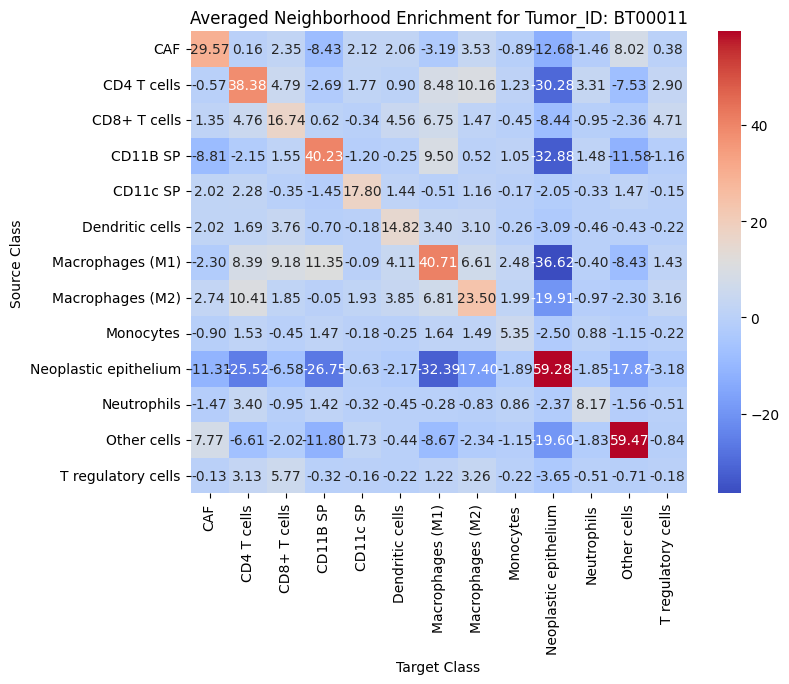

In [18]:

import seaborn as sns
# Visualize Tumor-Level Heatmaps
for tumor_id, avg_matrix in tumor_enrichment.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        avg_matrix,
        xticklabels=adata.obs['class'].cat.categories,
        yticklabels=adata.obs['class'].cat.categories,
        cmap="coolwarm",
        annot=True, 
        fmt=".2f"
    )
    plt.title(f"Averaged Neighborhood Enrichment for Tumor_ID: {tumor_id}")
    plt.xlabel("Target Class")
    plt.ylabel("Source Class")
    plt.savefig(f"heatmaps_per_tumor_new/neighborhood_enrichment_{tumor_id}.png",
                bbox_inches='tight')
    plt.show()